# Clean and Analyze Employee Exit Surveys

In this project, we will clean and analyze employee exit survey data from the Department of Education, Training, and Employment (DETE) as well as the Technical and Further Education Institute (TAFE) in Australia. The original DETE data can be found [here](https://data.gov.au/dataset/ds-qld-fe96ff30-d157-4a81-851d-215f2a0fe26d/details?q=exit%20survey). The TAFE data is no longer available. 

## Goals
The stakeholders for this project want to know the following:
- Are employees who only worked for the institutes for a short period of time resigning due to some kind of dissatisfaction? What about employees who have been there longer?
- Are younger employees resigning due to some kind of dissatisfaction? What about older employees?

## Data Dictionary
Some columns we will use from the DETE data:
- ```ID```: An id used to identify the participant of the survey
- ```SeparationType```: The reason why the person's employment ended
- ```Cease Date```: The year or month the person's employment ended
- ```DETE Start Date```: The year the person began employment with the DETE

Some columns we will use from the TAFE data:
- ```Record ID```: An id used to identify the participant of the survey
- ```Reason for ceasing employment```: The reason why the person's employment ended
- ```LengthofServiceOverall. Overall Length of Service at Institute (in years)```: The length of the person's employment (in years)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')


%matplotlib inline

In [2]:
dete_survey = pd.read_csv('dete_survey.csv',na_values='Not Stated')
tafe_survey = pd.read_csv('tafe_survey.csv')

In [3]:
dete_survey['DETE Start Date'].head()

0    1984.0
1       NaN
2    2011.0
3    2005.0
4    1970.0
Name: DETE Start Date, dtype: float64

In [4]:
dete_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 56 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ID                                   822 non-null    int64  
 1   SeparationType                       822 non-null    object 
 2   Cease Date                           788 non-null    object 
 3   DETE Start Date                      749 non-null    float64
 4   Role Start Date                      724 non-null    float64
 5   Position                             817 non-null    object 
 6   Classification                       455 non-null    object 
 7   Region                               717 non-null    object 
 8   Business Unit                        126 non-null    object 
 9   Employment Status                    817 non-null    object 
 10  Career move to public sector         822 non-null    bool   
 11  Career move to private sector   

In [5]:
tafe_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 72 columns):
 #   Column                                                                                                                                                         Non-Null Count  Dtype  
---  ------                                                                                                                                                         --------------  -----  
 0   Record ID                                                                                                                                                      702 non-null    float64
 1   Institute                                                                                                                                                      702 non-null    object 
 2   WorkArea                                                                                                                                  

The DETE survey contains 56 columns and 822 rows. A number of columns has missing data we might need to clean. Most data types are objects or boolean, except ID which is an integer.

The TAFE survey contains 72 columns and 702 rows. The majority of columns have some missing data. Most data types are objects.

In [6]:
dete_survey['DETE Start Date'].isnull().sum()
dete_survey['DETE Start Date'].value_counts()

2011.0    40
2007.0    34
2008.0    31
2010.0    27
2012.0    27
2009.0    24
2006.0    23
2013.0    21
1970.0    21
1975.0    21
1990.0    20
2005.0    20
1999.0    19
1996.0    19
1992.0    18
2004.0    18
1991.0    18
2000.0    18
1989.0    17
1976.0    15
1988.0    15
2002.0    15
2003.0    15
1978.0    15
1995.0    14
1979.0    14
1974.0    14
1980.0    14
1998.0    14
1997.0    14
1993.0    13
1986.0    12
1972.0    12
1977.0    11
1971.0    10
1994.0    10
1969.0    10
2001.0    10
1984.0    10
1981.0     9
1983.0     9
1973.0     8
1985.0     8
1987.0     7
1982.0     4
1963.0     4
1968.0     3
1967.0     2
1965.0     1
1966.0     1
Name: DETE Start Date, dtype: int64

The DETE survey has 0 missing IDs or Separation Types, which is good because those are directly related to our goals. 

Separation Type has 9 unique values. Both 'Resignation-Other reasons' and 'Other' might be able to be combined together. 

Missing data for DETE Start Date is listed as 'Not Stated.' Other dates are all four digit years.

Missing data for DETE Cease Date is listed as 'Not Stated.' There are two ways dates are stored for this column, as 4 digit years and mm/yyyy.

In [7]:
tafe_survey['LengthofServiceOverall. Overall Length of Service at Institute (in years)'].isnull().sum()
tafe_survey['LengthofServiceOverall. Overall Length of Service at Institute (in years)'].value_counts()

Less than 1 year      147
1-2                   102
3-4                    96
11-20                  89
More than 20 years     71
5-6                    48
7-10                   43
Name: LengthofServiceOverall. Overall Length of Service at Institute (in years), dtype: int64

The TAFE survey:

Record ID: no missing values

Reason for ceasing employment: 1 null value, 6 other unique values

Length of Service Overall: 106 null values. 7 other unique values, which are ranges of service

### Identify Missing Values and Drop Unnecessary Columns

We will go change what we did above to read 'Not Stated' as NANs in the DETE survey.

Then we will drop some columns from each dataframe that we won't use in our analysis to make the dataframes easier to work with. 

In [8]:
dete_survey_updated = dete_survey.drop(dete_survey.columns[28:49],
                                      axis=1)

In [9]:
dete_survey_updated.shape
dete_survey.shape

(822, 56)

In [10]:
tafe_survey_updated = tafe_survey.drop(tafe_survey.columns[17:66],
                                      axis=1)

In [11]:
tafe_survey.shape
tafe_survey_updated.shape

(702, 23)

## Clean Column Names

Each dataframe contain many of the same columns but the column names are different. We will want to combine columns later, so we first need to standardize the column names. 

For the DETE survey, we should:
- make all column names lowercase
- remove any trailing whitespace
- replace spaces with _

Since these are standardized changes, we will can use vectorized string methods to do this at once.

In [12]:
dete_survey_updated.columns = dete_survey_updated.columns.str.lower().str.strip().str.replace(' ', '_')

dete_survey.columns

Index(['ID', 'SeparationType', 'Cease Date', 'DETE Start Date',
       'Role Start Date', 'Position', 'Classification', 'Region',
       'Business Unit', 'Employment Status', 'Career move to public sector',
       'Career move to private sector', 'Interpersonal conflicts',
       'Job dissatisfaction', 'Dissatisfaction with the department',
       'Physical work environment', 'Lack of recognition',
       'Lack of job security', 'Work location', 'Employment conditions',
       'Maternity/family', 'Relocation', 'Study/Travel', 'Ill Health',
       'Traumatic incident', 'Work life balance', 'Workload',
       'None of the above', 'Professional Development',
       'Opportunities for promotion', 'Staff morale', 'Workplace issue',
       'Physical environment', 'Worklife balance',
       'Stress and pressure support', 'Performance of supervisor',
       'Peer support', 'Initiative', 'Skills', 'Coach', 'Career Aspirations',
       'Feedback', 'Further PD', 'Communication', 'My say', 'Inform

We also want to rename some of the TAFE survey colum names. We will use the ```DataFrame.rename()``` method to do this.

In [13]:
col_rename_dict = {'Record ID': 'id',
    'CESSATION YEAR': 'cease_date',
    'Reason for ceasing employment': 'separationtype',
    'Gender. What is your Gender?': 'gender',
    'CurrentAge. Current Age': 'age',
    'Employment Type. Employment Type': 'employment_status',
    'Classification. Classification': 'position',
    'LengthofServiceOverall. Overall Length of Service at Institute (in years)': 'institute_service',
    'LengthofServiceCurrent. Length of Service at current workplace (in years)': 'role_service'}

tafe_survey_updated.rename(columns=col_rename_dict,inplace=True)
#tafe_survey_updated.columns

In [14]:
tafe_survey_updated.columns

Index(['id', 'Institute', 'WorkArea', 'cease_date', 'separationtype',
       'Contributing Factors. Career Move - Public Sector ',
       'Contributing Factors. Career Move - Private Sector ',
       'Contributing Factors. Career Move - Self-employment',
       'Contributing Factors. Ill Health',
       'Contributing Factors. Maternity/Family',
       'Contributing Factors. Dissatisfaction',
       'Contributing Factors. Job Dissatisfaction',
       'Contributing Factors. Interpersonal Conflict',
       'Contributing Factors. Study', 'Contributing Factors. Travel',
       'Contributing Factors. Other', 'Contributing Factors. NONE', 'gender',
       'age', 'employment_status', 'position', 'institute_service',
       'role_service'],
      dtype='object')

## Filter the Data

Now that we have renamed the columns we will use for the analysis, we will remove some of the data we will not use. For this project, we will only look at the employees who *resigned*. 

In [14]:
dete_survey_updated['separationtype'].value_counts()

Age Retirement                          285
Resignation-Other reasons               150
Resignation-Other employer               91
Resignation-Move overseas/interstate     70
Voluntary Early Retirement (VER)         67
Ill Health Retirement                    61
Other                                    49
Contract Expired                         34
Termination                              15
Name: separationtype, dtype: int64

In [15]:
dete_resignations = dete_survey_updated[(dete_survey_updated['separationtype'] == 'Resignation-Other reasons') 
                                       | (dete_survey_updated['separationtype'] == 'Resignation-Other employer')
                                       | (dete_survey_updated['separationtype'] == 'Resignation-Move overseas/interstate')]

In [16]:
dete_resignations['separationtype'].value_counts()

Resignation-Other reasons               150
Resignation-Other employer               91
Resignation-Move overseas/interstate     70
Name: separationtype, dtype: int64

In [17]:
tafe_survey_updated['separationtype'].value_counts()

Resignation                 340
Contract Expired            127
Retrenchment/ Redundancy    104
Retirement                   82
Transfer                     25
Termination                  23
Name: separationtype, dtype: int64

In [18]:
tafe_resignations = tafe_survey_updated[tafe_survey_updated['separationtype'] == 'Resignation']

In [19]:
tafe_resignations['separationtype'].value_counts()

Resignation    340
Name: separationtype, dtype: int64

## Verify the Data

Before we start cleaning and manipulating the rest of our data, we should verify that the data does not contain any major inconsistencies. We will focus on verifying the ```cease_date``` and ```dete_start_date``` columns. We should check that the ```cease_data``` is after the ```dete_start date```. It is also unlikely that the start date was before the year 1940. 

In [20]:
dete_resignations['cease_date'].value_counts()

2012       126
2013        74
01/2014     22
12/2013     17
06/2013     14
09/2013     11
11/2013      9
07/2013      9
10/2013      6
08/2013      4
05/2013      2
05/2012      2
07/2012      1
07/2006      1
2010         1
09/2010      1
Name: cease_date, dtype: int64

In [21]:
# extract the year from DETE cease_date
# we want only the last four digits in each case

dete_resignations['cease_year'] = dete_resignations['cease_date'].str[-4:].astype(float)

<ipython-input-21-e9a430771b9a>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
dete_resignations['cease_year']

3      2012.0
5      2012.0
8      2012.0
9      2012.0
11     2012.0
        ...  
808    2013.0
815    2014.0
816    2014.0
819    2014.0
821    2013.0
Name: cease_year, Length: 311, dtype: float64

<ipython-input-24-68e5a0fe0643>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



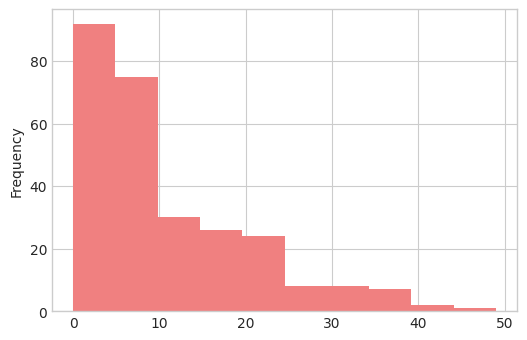

In [24]:
# check the values

# Calculate the years of service to see if there are any negative values
# we will save this to a new column to match the TAFE dataset

dete_resignations['institute_service'] = dete_resignations['cease_year'] - dete_resignations['dete_start_date']

#dete_resignations.head(15)
dete_resignations['institute_service'].plot.hist(color='lightcoral')
plt.show()

Since there are not negative years of employment, we know that there are no issues with the dates in the DETE dataset.

In [25]:
dete_resignations['cease_year'].value_counts()

2013.0    146
2012.0    129
2014.0     22
2010.0      2
2006.0      1
Name: cease_year, dtype: int64

In [26]:
tafe_resignations['cease_date'].value_counts()

2011.0    116
2012.0     94
2010.0     68
2013.0     55
2009.0      2
Name: cease_date, dtype: int64

For the TAFE dataset, these cease dates all look reasonable.

## Identify Dissatisfied Employees

We now want to identiy employees who resigned because they were dissatisfied. There are multiple, different columns in each survey that indicate job dissatisfaction. We will use these to create a new column called ```dissatisfied```. 

We will deal with the TAFE dataset first.

In [27]:
tafe_resignations['Contributing Factors. Dissatisfaction'].value_counts()

-                                         277
Contributing Factors. Dissatisfaction      55
Name: Contributing Factors. Dissatisfaction, dtype: int64

In [28]:
tafe_resignations['Contributing Factors. Job Dissatisfaction'].value_counts()

-                      270
Job Dissatisfaction     62
Name: Contributing Factors. Job Dissatisfaction, dtype: int64

In [29]:
# write a function to replace these columns with only True, False, or NaN

def update_vals(x):
    if x == pd.isnull(x):
        return np.nan
    elif x == '-':
        return False
    else:
        return True
    

In [30]:
factors = ['Contributing Factors. Dissatisfaction','Contributing Factors. Job Dissatisfaction']

tafe_map = tafe_resignations[factors].applymap(update_vals)

tafe_resignations['dissatisfied'] = tafe_map.any(axis=1, skipna=False).copy()

tafe_resignations_up = tafe_resignations.copy()

#tafe_resignations.head(15)

<ipython-input-30-999927a75681>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
dete_survey_updated['workload'].value_counts()

False    735
True      87
Name: workload, dtype: int64

In [32]:
dete_map = dete_survey_updated[['job_dissatisfaction','dissatisfaction_with_the_department',
                               'physical_work_environment','lack_of_recognition',
                               'lack_of_job_security','work_location',
                               'employment_conditions','work_life_balance','workload']]


dete_resignations['dissatisfied'] = dete_map.any(axis=1, skipna=False).copy()

dete_resignations_up = dete_resignations.copy()

#dete_resignation_up.head(15)

<ipython-input-32-fac3ae7307ca>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Combine the Data

Now we are ready to combine our data. We will want to aggreate our data according to the ```institute_service``` column.

First, we should add a column to each dataset helping us to distinguish between the two. 

In [33]:
dete_resignations_up['institute'] = 'DETE'
tafe_resignations_up['institute'] = 'TAFE'

In [34]:
# We will use pandas concat to combine
# We want to keep all the data at this point

combined = pd.concat([dete_resignations_up,tafe_resignations_up])

In [35]:
# drop any column with less than 500 non-null values

combined_updated = combined.dropna(axis=1,thresh=500)

In [36]:
combined_updated.tail()

,id,separationtype,cease_date,position,employment_status,gender,age,institute_service,dissatisfied,institute
696,6.350660e+17,Resignation,2013,Operational (OO),Temporary Full-time,Male,21 25,5-6,False,TAFE
697,6.350668e+17,Resignation,2013,Teacher (including LVT),Temporary Full-time,Male,51-55,1-2,False,TAFE
698,6.350677e+17,Resignation,2013,NaN,NaN,NaN,NaN,NaN,False,TAFE
699,6.350704e+17,Resignation,2013,Teacher (including LVT),Permanent Full-time,Female,51-55,5-6,False,TAFE
701,6.350730e+17,Resignation,2013,Administration (AO),Contract/casual,Female,26 30,3-4,False,TAFE


In [37]:
combined_updated.shape

(651, 10)

## Clean the Service Column

The ```institute_service``` column contains data in a few different formats. We will convert these formats and numbers into a few different categories for analysis. We will use the following definitions

- New: Less than 3 years at a company
- Experienced: 3-6 years at a company
- Established: 7-10 years at a company
- Veteran: 11 or more years at a company


In [38]:
# extract the years of service

pattern = r"(\d+)"


combined['institute_service'] = (combined['institute_service'].astype('str')
                                                              .str.extract(pattern)
                                                              .astype(float)                                
                                )

#combined['institute_service'].tail()

In [39]:
def map_career_state(value):
    '''Maps value to a corresponding service category'''
    if pd.isnull(value):
        return np.nan
    elif value < 3:
        return 'New'
    elif (value >=3 and value <=6):
        return 'Experienced'
    elif (value >=7 and value <=10):
        return 'Established'
    else:
        return 'Veteran'

# Apply function to the combined dataframe
combined['service_cat'] = combined['institute_service'].apply(map_career_state)



In [40]:
combined['service_cat'].tail()

696    Experienced
697            New
698            NaN
699    Experienced
701    Experienced
Name: service_cat, dtype: object

## Perform Initial Analysis

In [41]:
combined['dissatisfied'].value_counts(dropna=False)

False    403
True     248
Name: dissatisfied, dtype: int64

In [42]:
combined['service_cat'].value_counts(dropna=False)

New            193
Experienced    172
Veteran        136
NaN             88
Established     62
Name: service_cat, dtype: int64

In [43]:
pv = combined.pivot_table(index='service_cat',values='dissatisfied')
pv

,dissatisfied
service_cat,
Established,0.516129
Experienced,0.343023
New,0.295337
Veteran,0.485294


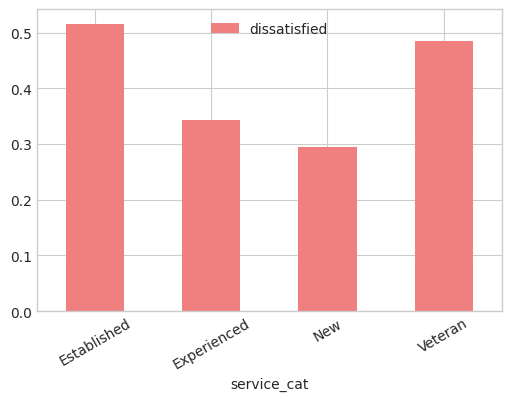

In [44]:
pv.plot(kind='bar',rot=30, color='lightcoral')